In [ ]:
# https://www.kaggle.com/code/nitinchoudhary012/car-object-detection
# https://github.com/dmlc/gluon-cv
import numpy as np
import pandas as pd
import tensorflow
from tensorflow.keras.layers import Conv2D,Flatten,Dense,MaxPool2D,Input
from tensorflow.keras.models import Model,Sequential
import matplotlib.pyplot as plt
import cv2
from PIL import Image
from sklearn.model_selection import train_test_split
import io
import os
from tensorflow.keras.preprocessing.image import img_to_array,load_img
# from tensorflow.keras.applications import VGG16
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint,ReduceLROnPlateau
from tensorflow.keras.models import load_model
import random
import imutils

import warnings
warnings.filterwarnings('ignore')

In [ ]:
! pip install -q kaggle

from google.colab import files

files.upload()

! mkdir ~/.kaggle

! cp kaggle.json ~/.kaggle/

! chmod 600 ~/.kaggle/kaggle.json

! kaggle datasets list

Saving kaggle.json to kaggle.json
ref                                                             title                                                size  lastUpdated          downloadCount  voteCount  usabilityRating  
--------------------------------------------------------------  --------------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
meirnizri/covid19-dataset                                       COVID-19 Dataset                                      5MB  2022-11-13 15:47:17           9650        283  1.0              
mattop/alcohol-consumption-per-capita-2016                      Alcohol Consumption Per Capita 2016                   4KB  2022-12-09 00:03:11           1005         38  1.0              
michals22/coffee-dataset                                        Coffee dataset                                       24KB  2022-12-15 20:02:12           1159         42  1.0              
thedevastator/jobs-dataset

In [ ]:
!kaggle datasets download -d mistag/arthropod-taxonomy-orders-object-detection-dataset

100% 11.1G/11.1G [08:38<00:00, 19.6MB/s]
100% 11.1G/11.1G [08:38<00:00, 23.0MB/s]


In [ ]:
!mkdir -p dataset && cd dataset && unzip /content/arthropod-taxonomy-orders-object-detection-dataset.zip

Se han truncado las últimas 5000 líneas del flujo de salida.
  inflating: ArTaxOr/Lepidoptera/c9b07301ed0e.jpg  
  inflating: ArTaxOr/Lepidoptera/c9d742746b8a.jpg  
  inflating: ArTaxOr/Lepidoptera/c9d78061b77d.jpg  
  inflating: ArTaxOr/Lepidoptera/ca2ff8921244.jpg  
  inflating: ArTaxOr/Lepidoptera/ca338092c0ec.jpg  
  inflating: ArTaxOr/Lepidoptera/ca35e5c89d94.jpg  
  inflating: ArTaxOr/Lepidoptera/ca4cb66fcd4a.jpg  
  inflating: ArTaxOr/Lepidoptera/ca5e1fe4cbc0.jpg  
  inflating: ArTaxOr/Lepidoptera/ca5e2a4139c0.jpg  
  inflating: ArTaxOr/Lepidoptera/ca63af0a9774.jpg  
  inflating: ArTaxOr/Lepidoptera/ca652f69b2e7.jpg  
  inflating: ArTaxOr/Lepidoptera/ca95914f205e.jpg  
  inflating: ArTaxOr/Lepidoptera/ca997241704b.jpg  
  inflating: ArTaxOr/Lepidoptera/cb0ad7fb32fa.jpg  
  inflating: ArTaxOr/Lepidoptera/cb0aec5a6b79.jpg  
  inflating: ArTaxOr/Lepidoptera/cb134256077c.jpg  
  inflating: ArTaxOr/Lepidoptera/cb22cb2317b4.jpg  
  inflating: ArTaxOr/Lepidoptera/cb35eb6c2e67.jpg  
  i

In [ ]:
import glob
import json

pfiles=glob.glob('/content/dataset/ArTaxOr/**/*.vott', recursive=True)
df=pd.DataFrame()
for f in pfiles:
    with open(f) as file:
        pdata=json.load(file)
        df=df.append(pd.DataFrame(list(pdata['assets'].values())), ignore_index=True)
df['path']=df['path'].str.replace('file:F:/','')
df.head()

,format,id,name,path,size,state,type
0,jpg,9c8f23b82ee4a2d682291faa7a56cbbf,00026d79d067.jpg,ArTaxOr/Lepidoptera/00026d79d067.jpg,"{'width': 3888, 'height': 2592}",2,1
1,jpg,9047380761065400114098ba4a37eb4c,00028c56bf09.jpg,ArTaxOr/Lepidoptera/00028c56bf09.jpg,"{'width': 5184, 'height': 3456}",2,1
2,jpg,511bf35dd66f49103ff9ee830d6022e0,00126d9a3bea.jpg,ArTaxOr/Lepidoptera/00126d9a3bea.jpg,"{'width': 4032, 'height': 3024}",2,1
3,jpg,518d6bc681b944adb5fbfecb2e78ac13,002b37ac08e1.jpg,ArTaxOr/Lepidoptera/002b37ac08e1.jpg,"{'width': 1920, 'height': 1521}",2,1
4,jpg,4338bc92a1392d3d5a61ed0c90a56be4,0032708c2542.jpg,ArTaxOr/Lepidoptera/0032708c2542.jpg,"{'width': 4608, 'height': 3456}",2,1


In [ ]:
tags=pd.DataFrame(list(pdata['tags']))
pattern=r'[A-Z]'
labels=tags[tags.name.str.match(pattern)]
labels

,name,color
0,Lepidoptera,#5db300
1,Coleoptera,#e81123
2,Hymenoptera,#6917aa
3,Diptera,#015cda
4,Araneae,#4894fe
5,Hemiptera,#257ffe
6,Odonata,#257ffe


In [ ]:
%%time
defi=pd.DataFrame(columns=['label', 'label_idx', 'xres', 'yres', 'height', 'width', 'left', 'top', 
                           'right', 'bottom', 'area', 'xcenter', 'ycenter', 'blurred',
                           'occluded', 'truncated', 'file', 'id'])
for i in range(len(df)):
    p=df['path'][i].split('/')
    p='/'.join(p[:2])
    afile='/content/dataset/'+p+'/annotations/'+df['id'][i]+'-asset.json'
    if os.path.isfile(afile):
        with open(afile) as file:
            adata=json.load(file)
        xres,yres=adata['asset']['size']['width'],adata['asset']['size']['height'] 
        for j in range(len(adata['regions'])):
            h=adata['regions'][j]['boundingBox']['height']/yres
            w=adata['regions'][j]['boundingBox']['width']/xres
            tags=adata['regions'][j]['tags']
            defi=defi.append({'label': tags[0],
                              'xres': xres,
                              'yres': yres,
                              'height': h,
                              'width': w,                              
                              'left': adata['regions'][j]['boundingBox']['left']/xres,
                              'top': adata['regions'][j]['boundingBox']['top']/yres,
                              'right': adata['regions'][j]['boundingBox']['left']/xres+w,
                              'bottom': adata['regions'][j]['boundingBox']['top']/yres+h, 
                              'area': h*w,
                              'xcenter': adata['regions'][j]['boundingBox']['left']/xres+0.5*w,
                              'ycenter': adata['regions'][j]['boundingBox']['top']/yres+0.5*h,
                              'blurred': int(any(ele == '_blurred' for ele in tags)),
                              'occluded': int(any(ele == '_occluded' for ele in tags)),
                              'truncated': int(any(ele == '_truncated' for ele in tags)),
                              'file': adata['asset']['path'].replace('file:F:/',''),
                              'id': adata['asset']['id'],}, ignore_index=True)

CPU times: user 1min 29s, sys: 1.7 s, total: 1min 31s
Wall time: 1min 36s


In [ ]:
defi.sample(5)

,label,label_idx,xres,yres,height,width,left,top,right,bottom,area,xcenter,ycenter,blurred,occluded,truncated,file,id
4463,Coleoptera,NaN,2048,1536,0.556513,0.814655,0.122486,0.215517,0.937141,0.772031,0.453367,0.529813,0.493774,0,0,0,ArTaxOr/Coleoptera/846529da6fce.jpg,a0d46ee3270a4e7f98ff243f777b3cce
9425,Hymenoptera,NaN,5431,3628,0.224974,0.141282,0.474156,0.727199,0.615438,0.952174,0.031785,0.544797,0.839687,0,0,0,ArTaxOr/Hymenoptera/54297a9a0308.jpg,dd8d2a42867336c070ed2c497800ffd5
3196,Coleoptera,NaN,2048,1536,0.457854,0.332615,0.292744,0.432950,0.625359,0.890805,0.152289,0.459052,0.661877,1,0,0,ArTaxOr/Coleoptera/0c4213ef7eaa.jpg,c5210116a742e9f66646cc1411579010
1275,Lepidoptera,NaN,1920,1440,0.840038,0.915948,0.054957,0.103448,0.970905,0.943487,0.769432,0.512931,0.523467,0,0,0,ArTaxOr/Lepidoptera/721f3230df21.jpg,e443c07b3d80fce690508acb496105ea
11400,Coleoptera,NaN,2048,1402,0.083585,0.101309,0.811854,0.513249,0.913163,0.596834,0.008468,0.862509,0.555042,1,0,0,ArTaxOr/Hymenoptera/f6103ca0cbd9.jpg,1d312048fd0853a8a70e367d1bcf0df0


In [ ]:
df2=pd.DataFrame(data={'xmin':defi['left']*defi['xres'],'xmin_sd':defi['left'],'ymin':defi['top']*defi['yres'],
                   'ymin_sd':defi['top'],'xmax':defi['right']*defi['xres'],'xmax_sd':defi['right'],'ymax':defi['bottom']*defi['yres'],
                   'ymax_sd':defi['bottom'],'label':defi['label'],'file':defi['file']})

In [ ]:
df2.label.value_counts()

Hymenoptera    3216
Hemiptera      2994
Lepidoptera    2899
Coleoptera     2793
Diptera        2673
Araneae        2527
Odonata        2503
Name: label, dtype: int64

In [ ]:
dict_classes={'Aranae':0,'Coleoptera':1,'Diptera':2,'Hemiptera':3,'Hymenoptera':4,'Lepidoptera':5,'Odonata':6}

In [ ]:
from sklearn.preprocessing import LabelBinarizer,LabelEncoder

lb = LabelEncoder()
labels = lb.fit_transform(df2.label)
np.unique(labels,return_counts=True)

(array([0, 1, 2, 3, 4, 5, 6]),
 array([2527, 2793, 2673, 2994, 3216, 2899, 2503]))

In [ ]:
df2['label_idx']=labels

In [ ]:
photo=plt.imread('/content/dataset/ArTaxOr/Hymenoptera/000167b01850.jpg')

In [ ]:
df2.head()

,xmin,xmin_sd,ymin,ymin_sd,xmax,xmax_sd,ymax,ymax_sd,label,file,label_idx
0,372.454859,0.095796,886.351086,0.341956,3057.345279,0.786354,2293.589969,0.884873,Lepidoptera,ArTaxOr/Lepidoptera/00026d79d067.jpg,5
1,2390.141971,0.461061,1549.91727,0.448471,3769.207443,0.727085,2682.856256,0.776289,Lepidoptera,ArTaxOr/Lepidoptera/00028c56bf09.jpg,5
2,1255.655172,0.311422,1094.896552,0.362069,1927.655172,0.478089,1781.37931,0.589080,Lepidoptera,ArTaxOr/Lepidoptera/00126d9a3bea.jpg,5
3,90.955994,0.047373,362.767241,0.238506,608.103187,0.316720,1021.284483,0.671456,Lepidoptera,ArTaxOr/Lepidoptera/002b37ac08e1.jpg,5
4,909.650986,0.473777,585.672414,0.385057,1222.852807,0.636903,955.724138,0.628352,Hymenoptera,ArTaxOr/Lepidoptera/002b37ac08e1.jpg,4


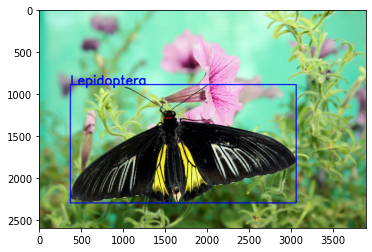

In [ ]:
photo=plt.imread('/content/dataset/ArTaxOr/Lepidoptera/00026d79d067.jpg')
xmin=df2.loc[0,'xmin']
ymin=df2.loc[0,'ymin']
xmax=df2.loc[0,'xmax']
ymax=df2.loc[0,'ymax']
pt1=(int(xmin),int(ymin))
pt2=(int(xmax),int(ymax))
color=(0,0, 255)
thickness = 12
cv2.putText(photo, 'Lepidoptera', (int(xmin), int(ymin)), cv2.FONT_HERSHEY_SIMPLEX,5, (0, 0, 255), 15)
cv2.rectangle(photo,pt1,pt2, color, thickness)
plt.figure()
plt.imshow(photo)

In [ ]:
images_folder_path="/content/dataset/"
df2['file']=images_folder_path+df2['file']

In [ ]:
df3=df2.groupby('label_idx').head(250)

In [ ]:
images=[load_img(i,target_size=(224,224)) for i in df3['file']]

In [ ]:
data=[img_to_array(i) for i in images]

In [ ]:
df3.columns

Index(['xmin', 'xmin_sd', 'ymin', 'ymin_sd', 'xmax', 'xmax_sd', 'ymax',
       'ymax_sd', 'label', 'file', 'label_idx'],
      dtype='object')

In [ ]:
data2 = np.array(data, dtype="float32") / 255.0
labels = np.array(df3['label_idx'],dtype='int')
bboxes = np.array(df3[['xmin_sd','ymin_sd','xmax_sd','ymax_sd']], dtype="float32")
imagePaths = np.array(df3.file)

In [ ]:
from sklearn.model_selection import train_test_split

split = train_test_split(data, labels, bboxes, imagePaths,
	test_size=0.20, random_state=42)
# unpack the data split
(trainImages, testImages) = split[:2]
(trainLabels, testLabels) = split[2:4]
(trainBBoxes, testBBoxes) = split[4:6]
(trainPaths, testPaths) = split[6:]

In [ ]:
from tensorflow.keras.applications import VGG16

vgg = VGG16(weights="imagenet", include_top=False,
	input_tensor=Input(shape=(224, 224, 3)))
# freeze all VGG layers so they will *not* be updated during the
# training process
vgg.trainable = False
# flatten the max-pooling output of VGG
flatten = vgg.output
flatten = Flatten()(flatten)

58889256/58889256 [==============================] - 0s 0us/step


In [ ]:
from tensorflow.keras.layers import Flatten, Dropout, Dense
# construct a fully-connected layer header to output the predicted
# bounding box coordinates
bboxHead = Dense(128, activation="relu")(flatten)
bboxHead = Dense(64, activation="relu")(bboxHead)
bboxHead = Dense(32, activation="relu")(bboxHead)
bboxHead = Dense(4, activation="sigmoid",
	name="bounding_box")(bboxHead)
# construct a second fully-connected layer head, this one to predict
# the class label
softmaxHead = Dense(512, activation="relu")(flatten)
softmaxHead = Dropout(0.5)(softmaxHead)
softmaxHead = Dense(512, activation="relu")(softmaxHead)
softmaxHead = Dropout(0.5)(softmaxHead)
softmaxHead = Dense(7, activation="softmax",
	name="class_label")(softmaxHead)
# put together our model which accept an input image and then output
# bounding box coordinates and a class label
model = Model(
	inputs=vgg.input,
	outputs=(bboxHead, softmaxHead))

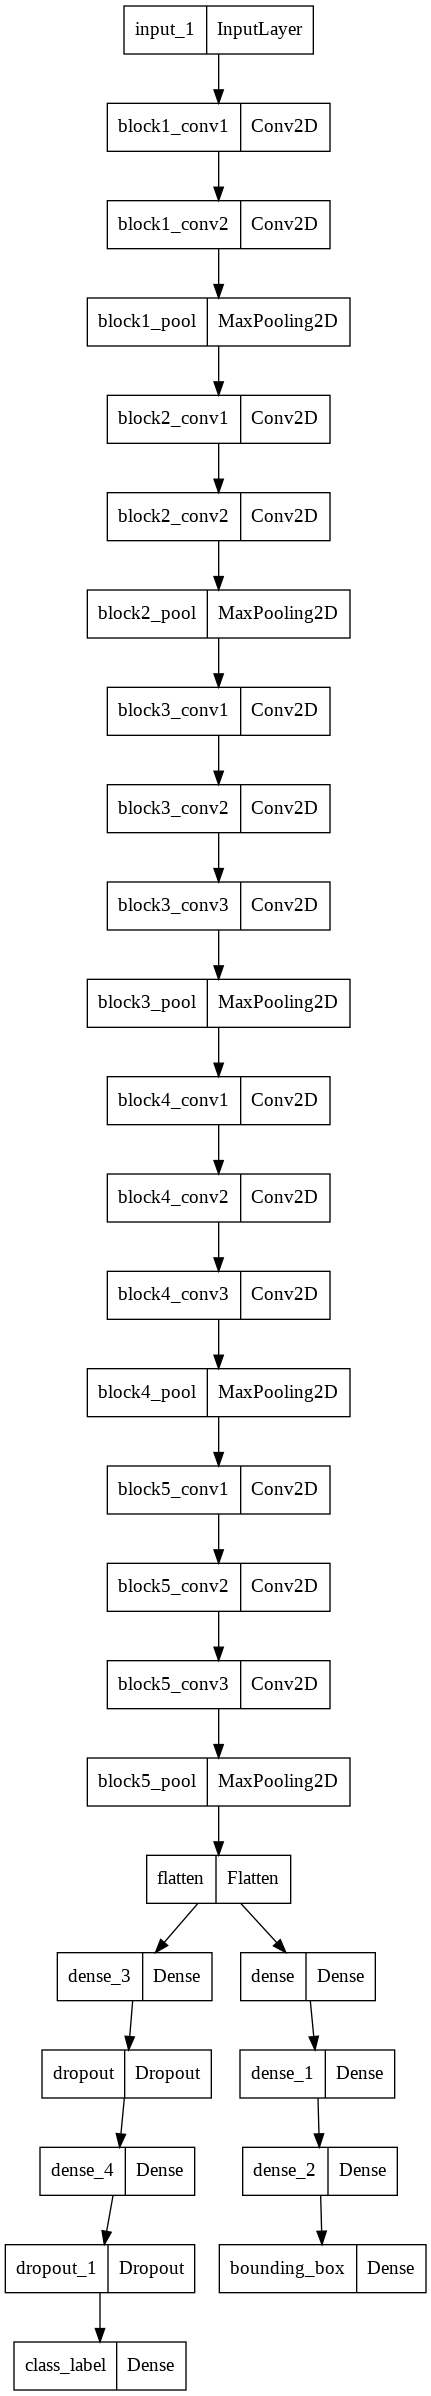

In [ ]:
from tensorflow.keras.utils import plot_model

plot_model(model)

In [ ]:
# define a dictionary to set the loss methods -- categorical
# cross-entropy for the class label head and mean absolute error
# for the bounding box head
losses = {
	"class_label": "SparseCategoricalCrossentropy",
	"bounding_box": "mean_squared_error",
}
# define a dictionary that specifies the weights per loss (both the
# class label and bounding box outputs will receive equal weight)
lossWeights = {
	"class_label": 1.0,
	"bounding_box": 1.0
}
# initialize the optimizer, compile the model, and show the model
# summary
opt = Adam(lr=0.00001)
model.compile(loss=losses, optimizer=opt, metrics=["accuracy"], loss_weights=lossWeights)
print(model.summary())

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 224, 224, 64  1792        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv2 (Conv2D)          (None, 224, 224, 64  36928       ['block1_conv1[0][0]']           
                                )                                                             

In [ ]:
# construct a dictionary for our target training outputs
trainTargets = {
	"class_label": trainLabels,
	"bounding_box": trainBBoxes
}
# construct a second dictionary, this one for our target testing
# outputs
testTargets = {
	"class_label": testLabels,
	"bounding_box": testBBoxes
}

In [ ]:
# train the network for bounding box regression and class label
# prediction
print("[INFO] training model...")
H = model.fit(
	np.array(trainImages), trainTargets,
	validation_data=(np.array(testImages), testTargets),
	batch_size=128,
	epochs=10,
	verbose=1)

[INFO] training model...
Epoch 1/10
11/11 [==============================] - 42s 2s/step - loss: 24.0754 - bounding_box_loss: 0.1969 - class_label_loss: 23.8786 - bounding_box_accuracy: 0.4279 - class_label_accuracy: 0.1650 - val_loss: 7.5978 - val_bounding_box_loss: 0.1567 - val_class_label_loss: 7.4411 - val_bounding_box_accuracy: 0.5229 - val_class_label_accuracy: 0.2257
Epoch 2/10
11/11 [==============================] - 8s 755ms/step - loss: 20.2483 - bounding_box_loss: 0.1307 - class_label_loss: 20.1176 - bounding_box_accuracy: 0.5321 - class_label_accuracy: 0.1850 - val_loss: 5.8593 - val_bounding_box_loss: 0.1196 - val_class_label_loss: 5.7397 - val_bounding_box_accuracy: 0.5457 - val_class_label_accuracy: 0.2886
Epoch 3/10
11/11 [==============================] - 8s 761ms/step - loss: 17.9819 - bounding_box_loss: 0.1077 - class_label_loss: 17.8742 - bounding_box_accuracy: 0.5393 - class_label_accuracy: 0.2150 - val_loss: 5.1244 - val_bounding_box_loss: 0.1086 - val_class_label

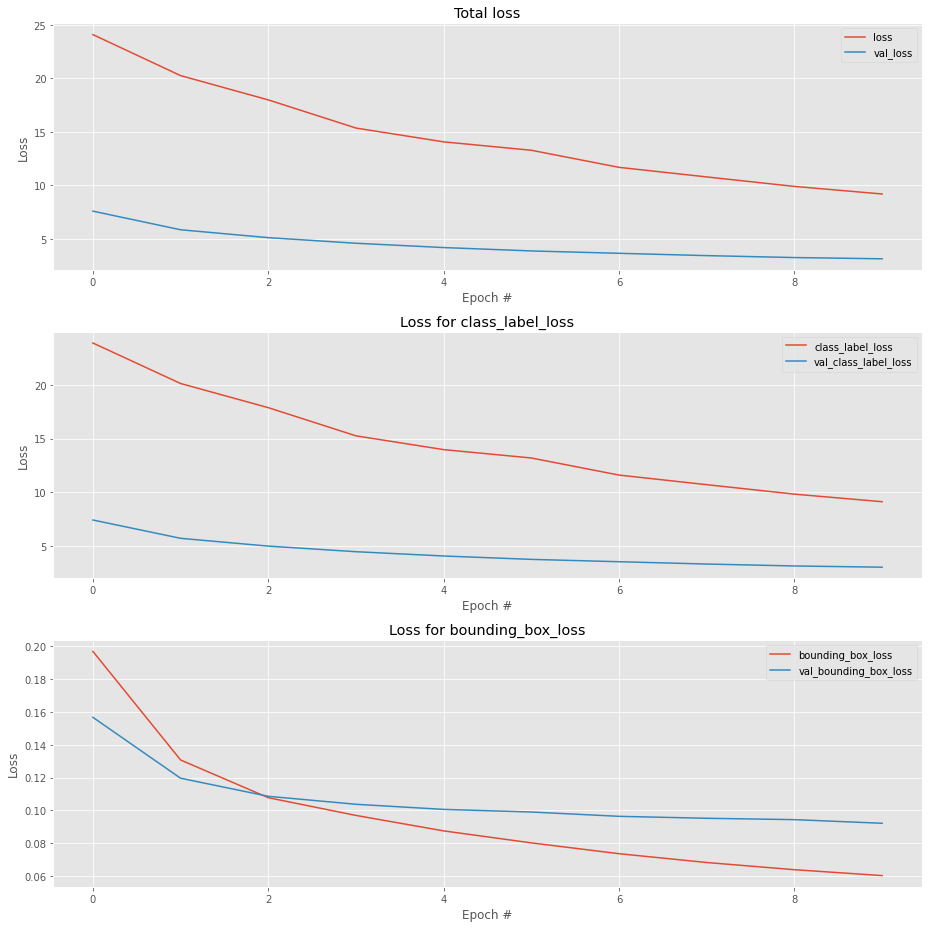

In [ ]:
# plot the total loss, label loss, and bounding box loss
lossNames = ["loss", "class_label_loss", "bounding_box_loss"]
N = np.arange(0, 10)
plt.style.use("ggplot")
(fig, ax) = plt.subplots(3, 1, figsize=(13, 13))
# loop over the loss names
for (i, l) in enumerate(lossNames):
	# plot the loss for both the training and validation data
	title = "Loss for {}".format(l) if l != "loss" else "Total loss"
	ax[i].set_title(title)
	ax[i].set_xlabel("Epoch #")
	ax[i].set_ylabel("Loss")
	ax[i].plot(N, H.history[l], label=l)
	ax[i].plot(N, H.history["val_" + l], label="val_" + l)
	ax[i].legend()
# save the losses figure and create a new figure for the accuracies
plt.tight_layout()

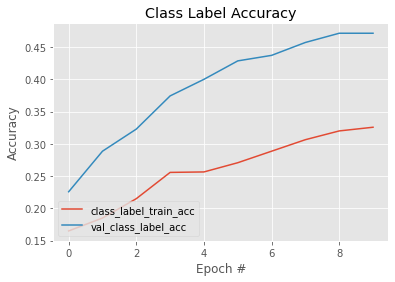

In [ ]:
# create a new figure for the accuracies
plt.style.use("ggplot")
plt.figure()
plt.plot(N, H.history["class_label_accuracy"],
	label="class_label_train_acc")
plt.plot(N, H.history["val_class_label_accuracy"],
	label="val_class_label_acc")
plt.title("Class Label Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Accuracy")
plt.legend(loc="lower left")

In [ ]:
image = load_img(testPaths[0], target_size=(224, 224))
image = img_to_array(image) / 255.0
image = np.expand_dims(image, axis=0)

In [ ]:
(boxPreds, labelPreds) =model.predict(image)

1/1 [==============================] - 1s 843ms/step


In [ ]:
dict_classes

{'Aranae': 0,
 'Coleoptera': 1,
 'Diptera': 2,
 'Hemiptera': 3,
 'Hymenoptera': 4,
 'Lepidoptera': 5,
 'Odonata': 6}

In [ ]:
for k,v in dict_classes.items():
  if v==np.argmax(labelPreds):
    print(k)

Lepidoptera


In [ ]:
d=np.random.choice(testPaths, 5)

In [ ]:
df2[df2.file=='/content/dataset/ArTaxOr/Hemiptera/00600a41bcaf.jpg']

,xmin,xmin_sd,ymin,ymin_sd,xmax,xmax_sd,ymax,ymax_sd,label,file,label_idx
11271,283.150575,0.184463,131.43295,0.064176,1360.79124,0.886509,1955.800766,0.954981,Hemiptera,/content/dataset/ArTaxOr/Hemiptera/00600a41bca...,3


In [ ]:
test_img.shape

(3456, 4608, 3)

1/1 [==============================] - 0s 19ms/step
2473 2343


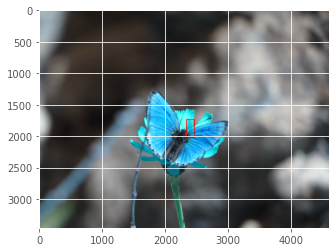

In [ ]:
image = load_img('/content/dataset/ArTaxOr/Lepidoptera/10ef70c53835.jpg', target_size=(224, 224))
image = img_to_array(image) / 255.0
image = np.expand_dims(image, axis=0)
# predict the bounding box of the object along with the class
# label
(boxPreds, labelPreds) = model.predict(image)
(startX, startY, endX, endY) = boxPreds[0]
test_img=cv2.imread('/content/dataset/ArTaxOr/Lepidoptera/10ef70c53835.jpg')
(h,w)=test_img.shape[:2]
startX=int(startX*w)
startY=int(startY*h)
endX=int(endX*w)
endY=int(endY*h)
cv2.rectangle(test_img,(startX,startY),(endX,endY),(255,0,0),10)
plt.imshow(test_img)
print(startX,endX)